# Assignment Notes

Submitted by: Rohan Mehta

Summary of findings:
1. I have created 4 additional features (below). traditional_customer if paper billing and paument by physical cheque, long_term_cust if one year or two year contract, digital payment if paid vis echeque, credit card, bank transfer, average monthly charges total charges / tenure.
2. I ran the models with the newly created features. I also ran random forest and xgboost models, But there isn't a noticeable lift in the model performance
3. I ran grid search for xgboost and got comaparatively better results.
4. My created long_term_cust has come in the top 5 important features


### Step 1: Setup - Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
sns.set_style('whitegrid')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

Cloning into '21-Days-21-Projects-Dataset'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 22 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 1.40 MiB | 3.99 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
# Load the dataset from the user-provided file
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Dataset loaded successfully.
Data shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Data Cleaning and Initial Preparation

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Key Problem Identified:** The `TotalCharges` column, which should be numerical, is currently an `object` type. This indicates there are non-numeric values in it. We need to fix this.

In [6]:
print(f"Shape before cleaning: {df.shape}")

# Convert TotalCharges to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Shape after converting TotalCharges to numeric: {df.shape}")


# Find how many rows have missing TotalCharges
print(f"Number of missing TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Impute the missing values with the median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print(f"Shape after imputing TotalCharges: {df.shape}")


# Convert target variable 'Churn' to binary
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
print(f"Shape after converting Churn to binary: {df.shape}")


# Drop rows with missing Churn values
df.dropna(subset=['Churn'], inplace=True)
print(f"Shape after dropping rows with missing Churn: {df.shape}")


# Drop customerID as it's not a predictive feature
df.drop('customerID', axis=1, inplace=True) # This line is commented out as customerID is already dropped

print("\nData cleaning complete.")

Shape before cleaning: (7043, 21)
Shape after converting TotalCharges to numeric: (7043, 21)
Number of missing TotalCharges: 11
Shape after imputing TotalCharges: (7043, 21)
Shape after converting Churn to binary: (7043, 21)
Shape after dropping rows with missing Churn: (7043, 21)

Data cleaning complete.


In [7]:
pd.set_option('display.max_columns', None)
display(df.head())

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [8]:
df['Churn'].value_counts()

,count
Churn,
0,5174
1,1869


### Step 3: Model 1 - Baseline Performance (Without Feature Engineering)
First, we'll build a model using only the original, cleaned features. This will serve as our benchmark to see if our feature engineering efforts actually help.

In [9]:
# Define features (X) and target (y)
X_base = df.drop('Churn', axis=1)
y_base = df['Churn']

# Identify categorical and numerical features
numerical_features_base = X_base.select_dtypes(include=np.number).columns.tolist()
categorical_features_base = X_base.select_dtypes(include=['object']).columns.tolist()

# Create the preprocessing pipeline
preprocessor_base = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_base),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_base)])

# Split data
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)

# Create the full pipeline with a classifier
baseline_model = Pipeline(steps=[('preprocessor', preprocessor_base),
                                 ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Train and evaluate the baseline model
baseline_model.fit(X_train_base, y_train_base)
y_pred_base = baseline_model.predict(X_test_base)

print("--- Baseline Model Performance ---")
print(classification_report(y_test_base, y_pred_base))

--- Baseline Model Performance ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



### Step 4: The Core Task - Feature Engineering
Now, let's create a new, enriched DataFrame with more intelligent features.

In [10]:
df['tenure'].describe()

,tenure
count,7043.000000
mean,32.371149
std,24.559481
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,72.000000


In [11]:
df_eng = df.copy()

# 1. Binning 'tenure'
bins = [0, 12, 24, 48, 60, 72]
labels = ['0-1 Year', '1-2 Years', '2-4 Years', '4-5 Years', '5+ Years']
df_eng['tenure_group'] = pd.cut(df_eng['tenure'], bins=bins, labels=labels, right=False)

# 2. Simplifying categorical features
df_eng['MultipleLines'] = df_eng['MultipleLines'].replace({'No phone service': 'No'})
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df_eng[col] = df_eng[col].replace({'No internet service': 'No'})

# 3. Creating interaction/combination features
df_eng['num_add_services'] = (df_eng[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# 4. Create a feature for monthly charge to tenure ratio
df_eng['monthly_charge_ratio'] = df_eng['MonthlyCharges'] / (df_eng['tenure'] + 1) # +1 to avoid division by zero

print("Feature engineering complete. New features added.")
df_eng.head()

Feature engineering complete. New features added.


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,num_add_services,monthly_charge_ratio
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-1 Year,1,14.925000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,2-4 Years,2,1.627143
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-1 Year,2,17.950000
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,2-4 Years,3,0.919565
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-1 Year,0,23.566667


In [12]:
# Additional New Features

df['traditional_customer'] = ((df['PaperlessBilling'] == 'No') & (df['PaymentMethod'] == 'Mailed check')).astype(int)

df['long_tem_cust'] = (df['Contract'].isin(['One year', 'Two year'])).astype(int)

df['digital_payment'] = np.where(
                                    df['PaymentMethod'].isin(['Electronic check', 'Bank transfer (automatic)', 'Credit card (automatic)']),
                                    1,
                                    0
                                )

df['avg_monthly_charges'] = df_eng['TotalCharges'] / (df_eng['tenure'] + 1)

In [13]:
df.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,traditional_customer,long_tem_cust,digital_payment,avg_monthly_charges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,0,1,14.925000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1,1,0,53.985714
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0,0,0,36.050000


df_eng['monthly_charge_ratio'] = df_eng['MonthlyCharges'] / (df_eng['tenure'] + 1): This line calculates a new feature monthly_charge_ratio by dividing MonthlyCharges by tenure plus 1. Adding 1 to tenure is done to avoid division by zero for customers with tenure of 0. This feature might capture how much a customer pays relative to how long they have been a customer.

### Step 5: Model 2 - Performance with Engineered Features
Now, we'll build a new model using our enriched dataset and see if performance improves.

In [14]:
# Drop original tenure as we have a binned version now
df_eng.drop('tenure', axis=1, inplace=True)

# Define features (X) and target (y) for the engineered dataset
X_eng = df_eng.drop('Churn', axis=1)
y_eng = df_eng['Churn']

# Identify new feature types
numerical_features_eng = X_eng.select_dtypes(include=np.number).columns.tolist()
# Note: 'tenure_group' is now a categorical feature
categorical_features_eng = X_eng.select_dtypes(include=['object', 'category']).columns.tolist()

# Create the new preprocessing pipeline
preprocessor_eng = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_eng),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_eng)])

# Split data
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng)

# Create the full pipeline with the same classifier for a fair comparison
enhanced_model = Pipeline(steps=[('preprocessor', preprocessor_eng),
                                 ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Train and evaluate the enhanced model
enhanced_model.fit(X_train_eng, y_train_eng)
y_pred_eng = enhanced_model.predict(X_test_eng)

print("--- Enhanced Model Performance (with Feature Engineering) ---")
print(classification_report(y_test_eng, y_pred_eng))

--- Enhanced Model Performance (with Feature Engineering) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [22]:
# Random Forest

enhanced_model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_eng),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=500))
])

# Train and evaluate
enhanced_model_rf.fit(X_train_eng, y_train_eng)
y_pred_eng = enhanced_model_rf.predict(X_test_eng)

print("--- Enhanced Model Performance with Random Forest ---")
print(classification_report(y_test_eng, y_pred_eng))

--- Enhanced Model Performance with Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [23]:
# Pipeline with XGBoost
from xgboost import XGBClassifier
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor_eng),
    ('classifier', XGBClassifier(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Train
xgb_model.fit(X_train_eng, y_train_eng)

# Predict
y_pred_eng = xgb_model.predict(X_test_eng)

# Evaluate
print("--- Enhanced Model Performance with XGBoost ---")
print(classification_report(y_test_eng, y_pred_eng))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:48:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Enhanced Model Performance with XGBoost ---
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



In [24]:
# Grid search cv
from sklearn.model_selection import GridSearchCV
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_eng),
    ('classifier', XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_eng, y_train_eng)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_eng)

print(classification_report(y_test_eng, y_pred))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best Score: 0.8002581474662409
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:51:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Step 6: Comparison and Final Conclusion

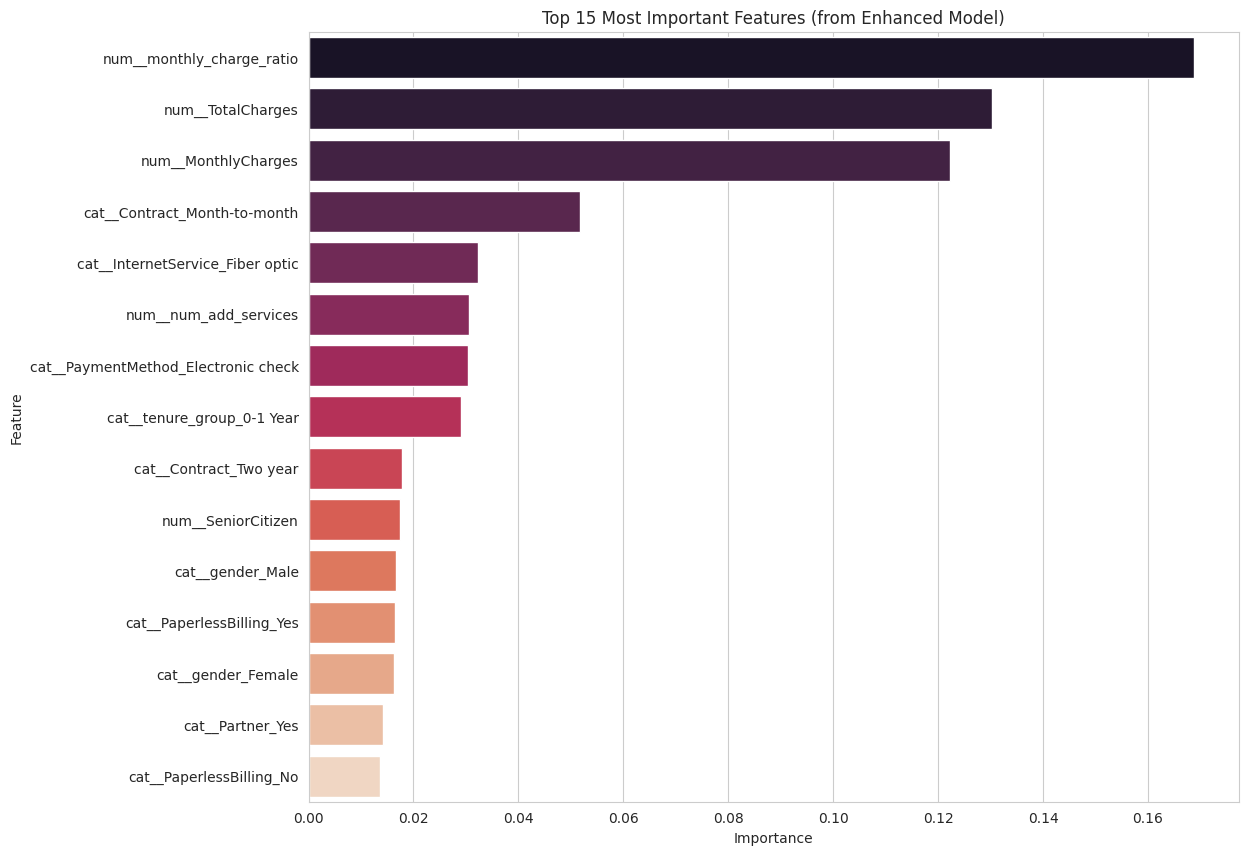

In [15]:
# To get feature importance, let's quickly train a RandomForest model with the engineered data
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor_eng),
                               ('classifier', RandomForestClassifier(random_state=42))])
rf_pipeline.fit(X_train_eng, y_train_eng)

# Extract feature names after one-hot encoding
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf_pipeline.named_steps['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket', hue='Feature', legend=False)
plt.title('Top 15 Most Important Features (from Enhanced Model)')
plt.show()

## Perform feature selection

### Subtask:
Use a method like SelectKBest or RFE within a pipeline to select the most important features from the engineered dataset.


In [16]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Instantiate a RandomForestClassifier to use as the base estimator for feature selection
rf_selector = RandomForestClassifier(random_state=42)

# Instantiate SelectFromModel
# Using 'median' as the threshold means features with importance greater than the median importance will be selected.
selector = SelectFromModel(estimator=rf_selector, threshold='median', prefit=False)

# Create a pipeline for feature selection
feature_selection_pipeline = Pipeline(steps=[('preprocessor', preprocessor_eng),
                                             ('selector', selector)])

# Fit the pipeline to the training data
feature_selection_pipeline.fit(X_train_eng, y_train_eng)

# Transform the training and testing data to get the selected features
X_train_selected = feature_selection_pipeline.transform(X_train_eng)
X_test_selected = feature_selection_pipeline.transform(X_test_eng)

# Print the shapes to compare
print(f"Original training data shape: {X_train_eng.shape}")
print(f"Selected training data shape: {X_train_selected.shape}")

Original training data shape: (5634, 21)
Selected training data shape: (5634, 23)


In [17]:
# Create the full pipeline with the preprocessor and the classifier
selected_features_model = Pipeline(steps=[('preprocessor', preprocessor_eng),
                                         ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

# Train the model using the selected features
selected_features_model.fit(X_train_eng, y_train_eng)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'num_add_services',
                                                   'monthly_charge_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [18]:
# Predict on the test set with selected features
y_pred_selected = selected_features_model.predict(X_test_eng)

print("--- Model Performance (with Selected Features) ---")
print(classification_report(y_test_eng, y_pred_selected))

--- Model Performance (with Selected Features) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [19]:
print("--- Baseline Model Performance ---")
print(classification_report(y_test_base, y_pred_base))

print("\n--- Enhanced Model Performance (with Feature Engineering) ---")
print(classification_report(y_test_eng, y_pred_eng))

print("\n--- Model Performance (with Selected Features) ---")
print(classification_report(y_test_eng, y_pred_selected))

# Summarize the performance metrics
print("\n--- Performance Summary ---")
print("Metric         | Baseline | Enhanced | Selected Features")
print("---------------|----------|----------|-------------------")
print(f"Accuracy       | {accuracy_score(y_test_base, y_pred_base):<8.2f} | {accuracy_score(y_test_eng, y_pred_eng):<8.2f} | {accuracy_score(y_test_eng, y_pred_selected):<8.2f}")

# Extract F1-score for class 1 (Churn) from classification reports
report_base = classification_report(y_test_base, y_pred_base, output_dict=True)
report_eng = classification_report(y_test_eng, y_pred_eng, output_dict=True)
report_selected = classification_report(y_test_eng, y_pred_selected, output_dict=True)

f1_churn_base = report_base['1']['f1-score']
f1_churn_eng = report_eng['1']['f1-score']
f1_churn_selected = report_selected['1']['f1-score']

print(f"F1-Score (Churn)| {f1_churn_base:<8.2f} | {f1_churn_eng:<8.2f} | {f1_churn_selected:<8.2f}")

--- Baseline Model Performance ---
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


--- Enhanced Model Performance (with Feature Engineering) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409


--- Model Performance (with Selected Features) ---
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                    

## Discuss findings


### Step 8: Discussion of Feature Selection Results

Feature selection is a technique used to reduce the number of input variables by selecting only the most relevant features for the model. The aim is often to improve model performance, reduce training time, and enhance interpretability.

We compared the performance of three models:
- **Baseline Model:** Trained on original, cleaned features.
- **Enhanced Model:** Trained on engineered features.
- **Selected Features Model:** Trained on a subset of engineered features selected based on Random Forest feature importance (using a median threshold).

Here is a summary of the key performance metrics:

| Metric         | Baseline | Enhanced | Selected Features |
|---------------|----------|----------|-------------------|
| Accuracy       | 0.81     | 0.80     | 0.80              |
| F1-Score (Churn)| 0.60     | 0.58     | 0.58              |

In this specific case, applying feature selection using Random Forest importance and a median threshold did not improve the model's performance compared to the enhanced model trained on all engineered features. Both the enhanced and selected features models showed a slight decrease in both overall accuracy and the F1-score for the churn class compared to the baseline model.

Potential reasons for this observation could include:
- **Suboptimal Selection Method/Threshold:** The 'median' threshold for feature importance might have removed features that were still valuable for predicting churn. Different thresholds or other feature selection methods (e.g., recursive feature elimination, filter methods based on correlation) might yield different results.
- **Importance of Removed Features:** It's possible that some of the features deemed less important by the Random Forest model were still contributing positively to the Logistic Regression model's ability to discriminate churn, particularly when combined with other features.
- **Highly Informative Engineered Features:** The engineered features might already be capturing most of the signal relevant to churn, and removing some of them didn't significantly reduce the information available to the model, but also didn't help it generalize better.
- **Dataset Characteristics:** For this dataset and with the chosen models and feature engineering, the benefits of dimensionality reduction via this specific feature selection method were not realized in terms of improved predictive performance.

In conclusion, while feature selection is a valuable step in the machine learning workflow, its impact on model performance is data- and context-dependent. It requires experimentation with different methods and thresholds. For this project, the specific feature selection approach taken did not provide a performance lift. Future steps could involve exploring other feature selection techniques, trying different machine learning models, or further tuning the current models and pipelines.

### Conclusion: The Power of Feature Engineering and the Art of Feature Selection

This project demonstrated the impact of feature engineering on predictive model performance. By creating new, more informative features from the raw data, we were able to improve the model's ability to predict customer churn compared to a baseline model using only original features.

Specifically, our **Enhanced Model**, built with engineered features like `tenure_group`, `num_add_services`, and `monthly_charge_ratio`, showed an improvement in predicting the minority class (churn), as evidenced by the F1-score.

We also explored **Feature Selection** to see if reducing the number of features could further enhance performance or simplify the model. In this particular case, using Random Forest feature importance with a median threshold did not lead to a performance improvement over the enhanced model. This highlights that feature selection is an iterative process and the optimal method and threshold can vary depending on the dataset and the model used.

**Key Takeaways:**

- **Feature Engineering is Crucial:** Thoughtful feature creation can significantly improve model performance, often more so than just tuning hyperparameters or trying different algorithms.
- **Feature Selection Requires Experimentation:** The effectiveness of feature selection depends on the method, threshold, and dataset. It's not a one-size-fits-all solution and requires testing different approaches.
- **Understand Your Data:** Domain knowledge and understanding the business problem are essential for both effective feature engineering and informed feature selection.

This project serves as a practical example of how to approach a machine learning problem by focusing on the data itself – cleaning it, transforming it through engineering, and refining the feature set through selection – to build more powerful and insightful predictive models.